# 我的第一个神经网络


在本课程中，我们将使用 [micrograd](https://github.com/karpathy/micrograd/tree/master) 库构建我们的第一个神经网络。Micrograd 是一个简单易懂的库，专门用于自动计算梯度。为了更好地掌握它，您可以观看 Andrej Karpathy 的 [介绍视频](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4s&ab_channel=AndrejKarpathy)（英文）。
这个 notebook 也受到了 micrograd 存储库中提供的 notebook 的启发。


## 使用 micrograd 构建神经网络


In [1]:
#!pip install micrograd # uncomment to install micrograd
import random
import numpy as np 
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

要构建一个神经网络，我们首先需要一个问题来解决。为此，我们使用 scikit-learn 的 [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) 函数来生成一个数据集。
为了简化后续步骤中的损失计算，我们将类别 0 和 1 替换为 -1 和 1。


### 初始化数据集


Les données d'entrée sont de la forme :  [-0.81882941  0.05879006]


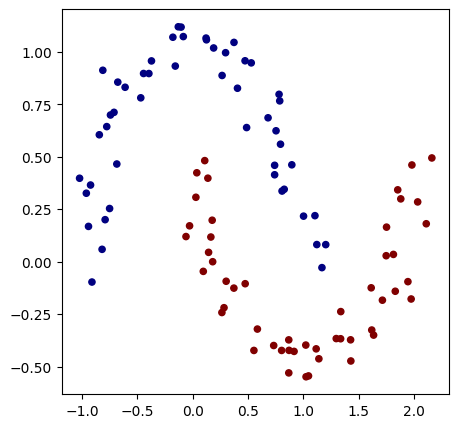

In [2]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) # 100 éléments et un bruit Gaussien d'écart type 0.1 ajouté sur les données 

print("Les données d'entrée sont de la forme : ",X[1])

y = y*2 - 1 # Pour avoir y=-1 ou y=1 (au lieu de 0 et 1)

# Visualisation des données en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### 创建神经网络


现在，我们将初始化我们的神经网络。该网络接受 2 个输入值，并必须产生标签 -1 或 1。
我们将要构建的网络具有 2 个隐藏层，每层包含 16 个神经元。每个神经元都像逻辑回归一样工作，这使得我们的网络是多个逻辑回归的非线性组合。

以下是该网络的架构概览：

![Mlp](./images/Mlp.png)


In [3]:
# Initialisation du modèle 
model = MLP(2, [16, 16, 1]) # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Nombre de paramètres 337


### 随机梯度下降（SGD）


在继续之前，让我们回顾一下随机梯度下降（SGD）。
要在大小为 $N$ 的数据集上应用梯度下降算法，理论上需要在每次迭代之前计算每个元素的损失和梯度。这种方法在每次迭代中都能保证损失减少，但对于 $N$ 很大的数据集（通常 $N>10⁶$）来说，它非常昂贵。此外，还需要在内存中存储所有 $N$ 个元素的梯度，这对于大型数据集来说是不可能的。

为了解决这个问题，我们使用 *mini-batch*，即数据集的样本组。优化过程与经典梯度下降类似，但权重更新是在每个 *mini-batch* 之后进行的（因此更频繁）。这使得优化过程更快，并允许处理大量数据。一个 *mini-batch* 的大小称为 *batch size*，其值通常为 16、32 或 64。
要了解有关随机梯度下降的更多信息，请参阅 [Wikipedia](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique) 或这篇 [博客文章](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31)。

让我们在 Python 中定义一个函数来从我们的数据集中获取 *batch_size* 个随机元素。


In [4]:
def get_batch(batch_size=64):
  ri = np.random.permutation(X.shape[0])[:batch_size]
  Xb, labels = X[ri], y[ri]
  #inputs = [list(map(Value, xrow)) for xrow in Xb] # OLD
  # Conversion des inputs en Value pour pouvoir utiliser micrograd
  inputs = [list([Value(xrow[0]),Value(xrow[1])]) for xrow in Xb]
  return inputs,labels

### 损失函数


为了训练我们的神经网络，我们需要定义一个损失函数（*loss*）。在我们的例子中，我们有两个类别，并且我们希望最大化不同类别的示例之间的间隔。与之前使用的负对数似然损失不同，我们试图最大化这个间隔，这使得我们的方法对新元素更加健壮。

我们使用 *max-margin loss*（最大间隔），定义为：
$\text{loss} = \max(0, 1 - y_i \cdot \text{score}_i)$


In [5]:
def loss_function(scores,labels):
  # La fonction .relu() prend le maximum entre 0 et la valeur de 1 - yi*scorei
  losses = [(1 - yi*scorei).relu() for yi, scorei in zip(labels, scores)]
  # On divise le loss par le nombre d'éléments du mini-batch
  data_loss = sum(losses) * (1.0 / len(losses))
  return data_loss

### 训练模型


现在我们已经有了训练的关键要素，是时候定义我们的训练循环了


In [6]:
# Définissons nos hyper-paramètres d'entraînement 
batch_size=128
iteration=50

现在我们可以启动模型的训练：


In [7]:
for k in range(iteration):
    
  # On récupère notre mini-batch random
  inputs,labels=get_batch(batch_size=batch_size)

  # On fait appel au modèle pour calculer les scores Y
  scores = list(map(model, inputs))
  
  # On calcule le loss
  loss=loss_function(scores,labels)


  accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
  accuracy=sum(accuracy) / len(accuracy)
  
  # Remise à zéro de valeurs de gradients avant de les calculer
  model.zero_grad() 
  # Calcul des gradients grâce à l'autograd de micrograd
  loss.backward() 
  
  # Mise à jour des poids avec les gradients calculés (SGD)
  learning_rate = 1.0 - 0.9*k/100 # On diminue le learning rate au fur et à mesure de l'entraînement
  for p in model.parameters():
      p.data -= learning_rate * p.grad
  
  if k % 1 == 0:
      print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.8862514464368221, accuracy 50.0%
step 1 loss 1.7136790633950052, accuracy 81.0%
step 2 loss 0.733396126728699, accuracy 77.0%
step 3 loss 0.7615247055858604, accuracy 82.0%
step 4 loss 0.35978083334534205, accuracy 84.0%
step 5 loss 0.3039360355411295, accuracy 86.0%
step 6 loss 0.2716587340549048, accuracy 89.0%
step 7 loss 0.25896576803013205, accuracy 91.0%
step 8 loss 0.2468445503533517, accuracy 91.0%
step 9 loss 0.26038987927745966, accuracy 91.0%
step 10 loss 0.23569710047306525, accuracy 91.0%
step 11 loss 0.2403768930229477, accuracy 92.0%
step 12 loss 0.20603128479123115, accuracy 91.0%
step 13 loss 0.22061157796029193, accuracy 93.0%
step 14 loss 0.19010711228374735, accuracy 92.0%
step 15 loss 0.21687609382796402, accuracy 93.0%
step 16 loss 0.18642445342175254, accuracy 92.0%
step 17 loss 0.2064478196088666, accuracy 92.0%
step 18 loss 0.15299793102189654, accuracy 94.0%
step 19 loss 0.18164592701596197, accuracy 93.0%
step 20 loss 0.15209012673698674, accura

如您所见，损失值并不在每次训练步骤中都会减少。这可以用随机梯度下降来解释：在每次迭代中不考虑整个数据集会引入一定的随机性。然而，损失值在训练过程中平均减少，这使得我们能够更快地获得一个健壮的模型。


(-1.548639298268643, 1.951360701731357)

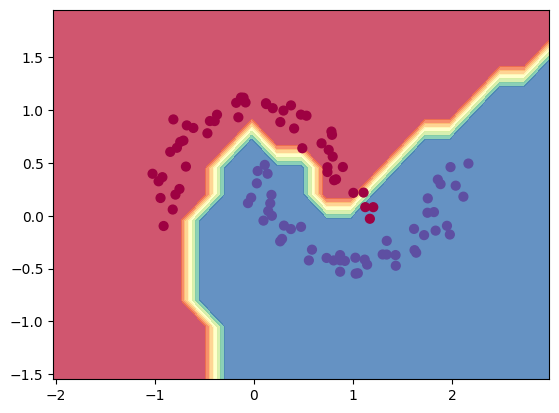

In [8]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())